In [2]:
!pip install gensim==4.0.1

     |████████████████████████████████| 23.9MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
!pip install lime

     |████████████████████████████████| 276kB 16.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=c3ec1cd1c08278f00007cd9e2b9a62860f5fa5fa22e9e1d85cc1ca412deecc50
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [4]:
import nltk
import lime
from nltk.corpus import brown
from nltk.data import find
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
# %%capture
# !wget https://raw.githubusercontent.com/kashkambath/cvd-reddit-nlp-analysis/swetha/data/NN_Data.csv

In [60]:
df = pd.read_csv('NN_Data_2.0_cleaned_2.csv')
if 'Unnamed: 0' in df.columns:
  df = df.drop(columns=['Unnamed: 0'])
df = df[df['text'].notna()] # remove missing rows
df.head()

,text,outcome
0,My dad had a heart attack and spent over 7 min...,1.0
1,I had dangerous open heart surgery due to mult...,1.0
2,"In June of 2020, my Dad collapsed in our yard ...",1.0
3,"after my twin aunts were born, my grandma beca...",1.0
4,Not me but my mother is the most severe case I...,1.0


In [61]:
df["no_punct"] = df['text'].str.replace('[^\w\s]','')
df['str_list'] = df.no_punct.apply(lambda s: s.split(' '))

In [62]:
df.head()

,text,outcome,no_punct,str_list
0,My dad had a heart attack and spent over 7 min...,1.0,My dad had a heart attack and spent over 7 min...,"[My, dad, had, a, heart, attack, and, spent, o..."
1,I had dangerous open heart surgery due to mult...,1.0,I had dangerous open heart surgery due to mult...,"[I, had, dangerous, open, heart, surgery, due,..."
2,"In June of 2020, my Dad collapsed in our yard ...",1.0,In June of 2020 my Dad collapsed in our yard w...,"[In, June, of, 2020, my, Dad, collapsed, in, o..."
3,"after my twin aunts were born, my grandma beca...",1.0,after my twin aunts were born my grandma becam...,"[after, my, twin, aunts, were, born, my, grand..."
4,Not me but my mother is the most severe case I...,1.0,Not me but my mother is the most severe case I...,"[Not, me, but, my, mother, is, the, most, seve..."


In [94]:
df['outcome'].value_counts()

0.0    1443
1.0     694
Name: outcome, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59543d3650>]],
      dtype=object)

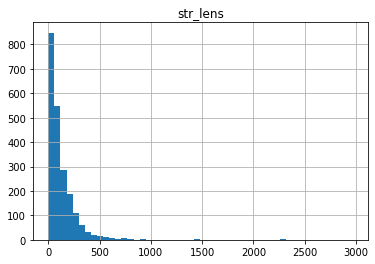

In [63]:
df['str_lens'] = df['str_list'].apply(lambda s: len(s))
df.hist('str_lens', bins=50)

In [64]:
df = df[df['str_lens'] < 750]
df.head()

,text,outcome,no_punct,str_list,str_lens
0,My dad had a heart attack and spent over 7 min...,1.0,My dad had a heart attack and spent over 7 min...,"[My, dad, had, a, heart, attack, and, spent, o...",187
1,I had dangerous open heart surgery due to mult...,1.0,I had dangerous open heart surgery due to mult...,"[I, had, dangerous, open, heart, surgery, due,...",63
2,"In June of 2020, my Dad collapsed in our yard ...",1.0,In June of 2020 my Dad collapsed in our yard w...,"[In, June, of, 2020, my, Dad, collapsed, in, o...",256
3,"after my twin aunts were born, my grandma beca...",1.0,after my twin aunts were born my grandma becam...,"[after, my, twin, aunts, were, born, my, grand...",182
4,Not me but my mother is the most severe case I...,1.0,Not me but my mother is the most severe case I...,"[Not, me, but, my, mother, is, the, most, seve...",165


In [65]:
w2v = Word2Vec(df['str_list'].tolist(), min_count=1, vector_size= 300, workers=3, window =3, sg = 1)

In [66]:
kv = w2v.wv

In [67]:
EMBEDDING_DIM = len(kv['heart'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = kv.vectors
vocab_dict = kv.key_to_index

In [68]:
embedding_matrix.shape

(17332, 300)

In [69]:
list(vocab_dict.items())[:20]

[('to', 0),
 ('I', 1),
 ('and', 2),
 ('the', 3),
 ('a', 4),
 ('of', 5),
 ('my', 6),
 ('you', 7),
 ('in', 8),
 ('that', 9),
 ('it', 10),
 ('', 11),
 ('was', 12),
 ('for', 13),
 ('is', 14),
 ('with', 15),
 ('me', 16),
 ('but', 17),
 ('have', 18),
 ('on', 19)]

In [70]:
def sents_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = [vocab_dict[word] for word in sentences]
    return np.asarray(text_ids).astype(np.int64)

In [71]:
df["id_list"] = df["str_list"].apply(sents_to_ids)
# df["outcome_2d"] = df["outcome"].apply(lambda x: np.asarray([x]).astype(np.int64))
X = np.array(df["id_list"])
# y = np.array(df["outcome_2d"])
y = np.array(df['outcome'].tolist()).astype('float32')

In [72]:
df[["str_list", "id_list"]].head()

,str_list,id_list
0,"[My, dad, had, a, heart, attack, and, spent, o...","[70, 120, 25, 4, 65, 119, 2, 571, 101, 588, 46..."
1,"[I, had, dangerous, open, heart, surgery, due,...","[1, 25, 2089, 379, 65, 412, 441, 0, 642, 3269,..."
2,"[In, June, of, 2020, my, Dad, collapsed, in, o...","[352, 4024, 5, 10193, 6, 666, 2289, 8, 153, 33..."
3,"[after, my, twin, aunts, were, born, my, grand...","[105, 6, 6714, 1935, 74, 1090, 6, 579, 719, 39..."
4,"[Not, me, but, my, mother, is, the, most, seve...","[388, 16, 17, 6, 260, 14, 3, 136, 918, 621, 1,..."


In [73]:
X = pad_sequences(X).astype('float32') # zero pre-padding

In [74]:
X.shape

(2137, 732)

In [75]:
MAX_SEQUENCE_LENGTH = X.shape[1]  # Keras' embedding layer expects a specific input length. Padding is often needed here.

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [88]:
try:
    del reg_model
except:
    pass

reg_model = tf.keras.Sequential()

reg_model.add(embedding_layer)                                        # embedding layer

reg_model.add(tf.keras.layers.GlobalMaxPooling1D())

reg_model.add(Dense(100, activation='relu'))                          # hidden layer

reg_model.add(Dense(1, activation='sigmoid'))                         # classification layer

In [89]:
reg_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 732, 300)          5199600   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 5,229,801
Trainable params: 30,201
Non-trainable params: 5,199,600
_________________________________________________________________


In [90]:
reg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
reg_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

Epoch 1/20
47/47 [==============================] - 1s 14ms/step - loss: 0.6531 - accuracy: 0.6410 - val_loss: 0.6318 - val_accuracy: 0.6760
Epoch 2/20
47/47 [==============================] - 1s 12ms/step - loss: 0.6098 - accuracy: 0.6943 - val_loss: 0.6248 - val_accuracy: 0.6760
Epoch 3/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6298 - accuracy: 0.6598 - val_loss: 0.6180 - val_accuracy: 0.6760
Epoch 4/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6284 - accuracy: 0.6635 - val_loss: 0.6189 - val_accuracy: 0.6760
Epoch 5/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6214 - accuracy: 0.6705 - val_loss: 0.6112 - val_accuracy: 0.6760
Epoch 6/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6098 - accuracy: 0.6777 - val_loss: 0.6081 - val_accuracy: 0.6760
Epoch 7/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6094 - accuracy: 0.6797 - val_loss: 0.6064 - val_accuracy: 0.6791
Epoch 8/20
47

## Metrics for Basic Softmax Classifier

In [93]:
y_pred_reg_model = reg_model.predict(X_test).round()
print(classification_report(y_test, y_pred_reg_model))

              precision    recall  f1-score   support

         0.0       0.70      0.98      0.81       434
         1.0       0.71      0.12      0.21       208

    accuracy                           0.70       642
   macro avg       0.71      0.55      0.51       642
weighted avg       0.70      0.70      0.62       642



In [81]:
try:
    del tf_model
except:
    pass

tf_model = tf.keras.Sequential()

tf_model.add(embedding_layer)                                        # embedding layer


tf_model.add(tf.keras.layers.Conv1D(
    filters=5, 
    kernel_size=3, 
    strides=1, 
    padding='same', 
    activation='relu', 
    use_bias=True,
    kernel_initializer='glorot_uniform', 
    bias_initializer='zeros')
            )   

tf_model.add(tf.keras.layers.GlobalMaxPooling1D())

tf_model.add(Dense(100, activation='relu'))                          # hidden layer
tf_model.add(Dense(1, activation='sigmoid'))                         # classification layer

In [82]:
tf_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 732, 300)          5199600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 732, 5)            4505      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 5)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 5,204,806
Trainable params: 5,206
Non-trainable params: 5,199,600
_________________________________________________________________


In [83]:
tf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')


In [85]:
tf_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)


Epoch 1/20
47/47 [==============================] - 1s 16ms/step - loss: 0.6052 - accuracy: 0.6709 - val_loss: 0.6196 - val_accuracy: 0.6760
Epoch 2/20
47/47 [==============================] - 1s 15ms/step - loss: 0.6044 - accuracy: 0.6749 - val_loss: 0.6258 - val_accuracy: 0.6760
Epoch 3/20
47/47 [==============================] - 1s 14ms/step - loss: 0.6024 - accuracy: 0.6729 - val_loss: 0.6206 - val_accuracy: 0.6620
Epoch 4/20
47/47 [==============================] - 1s 14ms/step - loss: 0.6023 - accuracy: 0.6742 - val_loss: 0.6172 - val_accuracy: 0.6838
Epoch 5/20
47/47 [==============================] - 1s 14ms/step - loss: 0.6025 - accuracy: 0.6783 - val_loss: 0.6202 - val_accuracy: 0.6760
Epoch 6/20
47/47 [==============================] - 1s 14ms/step - loss: 0.6032 - accuracy: 0.6776 - val_loss: 0.6207 - val_accuracy: 0.6760
Epoch 7/20
47/47 [==============================] - 1s 14ms/step - loss: 0.5989 - accuracy: 0.6763 - val_loss: 0.6180 - val_accuracy: 0.6760
Epoch 8/20
47

In [86]:
y_pred_tf_model = tf_model.predict(X_test).round()
print(y_pred_tf_model.shape)
print(classification_report(y_test, y_pred_tf_model))

(642, 1)
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       434
         1.0       0.50      0.00      0.01       208

    accuracy                           0.68       642
   macro avg       0.59      0.50      0.41       642
weighted avg       0.62      0.68      0.55       642



In [95]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 16.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491635 sha256=aa887faaf0e5c102b508890e9d79a61fd24651f93c5ba63fc36b4ba470445cde
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [97]:
explainer = shap.Explainer(tf_model)
explainer

In [ ]:
[print(i.shape, i.dtype) for i in tf_model.inputs]
[print(o.shape, o.dtype) for o in tf_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in tf_model.layers]